In [73]:
# Libraries import
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector, Operator, DensityMatrix
from qiskit_aer import AerSimulator

C:\Users\giova\AppData\Local\Temp\ipykernel_9220\3785090123.py:34: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(1).c_if(0, 1)
C:\Users\giova\AppData\Local\Temp\ipykernel_9220\3785090123.py:47: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.h(1).c_if(0, 0)
C:\Users\giova\AppData\Local\Temp\ipykernel_9220\3785090123.py:57: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.cx(0, 1).c_if(0, 1)
C:\Users\giova\AppData\Local\Temp\ipykernel_9220\3785090123.py:71: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.measure([0, 1], [temp[0], temp[1]]).c_if(0, 0)


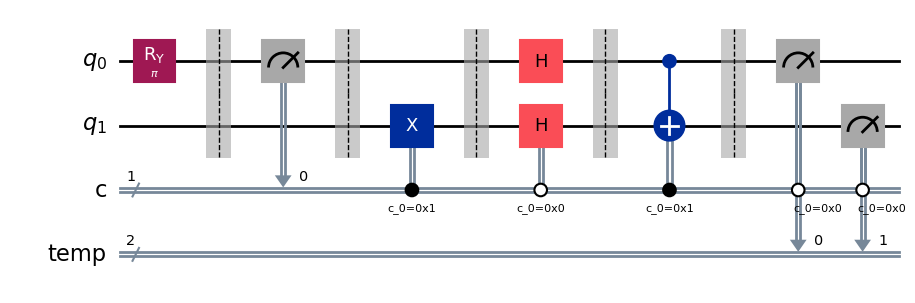

In [206]:

# Get Qiskit version
qiskit_version = qiskit.version.get_version_info()

def specialized_werner_states_generator(theta: float) -> QuantumCircuit:
    """
    A specialized circuit for generating Werner states with a given parameter theta.

    Args:
        theta: The parameter theta for the Werner state (in radians).
    
    Returns:
        A QuantumCircuit that generates the Werner state.
    """

    # Create a quantum circuit with 2 qubits and 1 classical bit
    qc = QuantumCircuit(QuantumRegister(2, "q"), ClassicalRegister(1, "c"))

    # Apply the R_y(theta) gate to the first qubit
    qc.ry(theta, 0)

    qc.barrier()

    # Measure the first qubit
    qc.measure(0, 0)

    qc.barrier()

    # Apply X gate on the second qubit if the measurement outcome is 1
    if int(qiskit_version.split('.')[0]) < 2:
        qc.x(1).c_if(0, 1)
    else:
        # From Qiskit 2.0.0.
        with qc.if_test((0, 1)):
            qc.x(1)

    qc.barrier()

    # Apply Hadamard gate on the first qubit
    qc.h(0)

    # Apply Hadamard gate on the second qubit if the measurement outcome is 0
    if int(qiskit_version.split('.')[0]) < 2:
        qc.h(1).c_if(0, 0)
    else:
        # From Qiskit 2.0.0.
        with qc.if_test((0, 0)):
            qc.h(1)

    qc.barrier()

    # Apply CNOT gate if the measurement outcome is 1
    if int(qiskit_version.split('.')[0]) < 2:
        qc.cx(0, 1).c_if(0, 1)
    else: 
        # From Qiskit 2.0.0.
        with qc.if_test((0, 1)):
            qc.cx(0, 1)

    qc.barrier()

    # Measure both qubits if the previous measurement outcome is 0
    # We do not want to preserve the results of these measurements.
    # So we create a new classical register with 2 bits, called "temp"
    temp = ClassicalRegister(2, "temp")
    qc.add_register(temp)
    if int(qiskit_version.split('.')[0]) < 2:
        qc.measure([0, 1], [temp[0], temp[1]]).c_if(0, 0)
    else:
        # From Qiskit 2.0.0.
        with qc.if_test((0, 0)):
            qc.measure([0, 1], [temp[0], temp[1]])

    return qc



qc = specialized_werner_states_generator(np.pi)
# draw the circuit
qc.draw('mpl')
    

In [64]:
# The following structure will be used to store all the information
# related to the nodes in the network (Alice and Bob)
Nodes = {}

# Alice and Bob are the two parties
Nodes["Alice"] = {}
Nodes["Bob"] = {}

In [65]:
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

# Alice's observables
Nodes["Alice"]["observables"] = []
# A0
Nodes["Alice"]["observables"].append(Z)
# A1
Nodes["Alice"]["observables"].append(X)
# A2
Nodes["Alice"]["observables"].append(-(Z + X) / np.sqrt(2))

# Bob's observables
Nodes["Bob"]["observables"] = []
# B0
Nodes["Bob"]["observables"].append(Z)
# B1
Nodes["Bob"]["observables"].append((Z - X) / np.sqrt(2))
# B2
Nodes["Bob"]["observables"].append(-(Z + X) / np.sqrt(2))

In [69]:
# Before performing the measurements using such observables,
# we need to do the following:
#   1. Compute eigenvalues and eigenvectors of each observable.
#   2. Find the unitary transformation that maps the eigenvalues of the observables to the standard basis.
#   3. Apply the found unitary transformation to the qubits before measuring them (in the standard basis).
#   4. This is as if we are measuring the qubits using the observables.


for node in Nodes:
    
    Nodes[node]["unitaries"] = []

    for i in range(len(Nodes[node]["observables"])):
        
        # Step 1: Compute eigenvalues and eigenvectors of each observable.
        eigenvalues, eigenvectors = np.linalg.eig(Nodes[node]["observables"][i])

        # Step 2: Find the unitary transformation that maps the eigenvalues of the observables to the standard basis.

        # Constructing the coefficient matrix of the linear system to solve
        A = np.array([[eigenvectors[:,0][0], eigenvectors[:,0][1], 0, 0], [0, 0, eigenvectors[:,0][0], eigenvectors[:,0][1]], [eigenvectors[:,1][0], eigenvectors[:,1][1], 0, 0], [0, 0, eigenvectors[:,1][0], eigenvectors[:,1][1]]])

        # Vector of the known terms
        b = np.array([1, 0, 0, 1])

        # Solve the system
        x = np.linalg.solve(A, b)

        # Construct the unitary transformation matrix
        U = np.array([[x[0], x[1]], [x[2], x[3]]])
        
        # Checking if the matrix is unitary
        assert np.allclose(np.eye(2), U @ U.conj().T)

        Nodes[node]["unitaries"].append(U)


In [146]:
# Now we can prepare the measurements circuits using the unitaries we have just found.

for node in Nodes:
    
    Nodes[node]["measurement_circuits"] = []

    for i in range(len(Nodes[node]["unitaries"])):
        
        # Create a quantum circuit with 1 qubit and 1 classical bit
        qc = QuantumCircuit(QuantumRegister(1, "oQ"), ClassicalRegister(1, "oC"))

        # Apply the unitary transformation to the qubits
        qc.unitary(Nodes[node]["unitaries"][i], 0)

        # Transplie the circuit 
        transpiled_qc = transpile(qc, basis_gates=['u3', 'cx'])

        # Measure the qubit
        transpiled_qc.measure(0, 0)
        
        # transpiled_qc.global_phase = 0

        Nodes[node]["measurement_circuits"].append(transpiled_qc)

In [196]:
key_length = 100
# Trovare formula che leghi epr_pairs a key_length
epr_pairs = 500

import random

alice_basis = [random.randint(0, 2) for i in range(epr_pairs)]
bob_basis = [random.randint(0, 2) for i in range(epr_pairs)]


In [241]:
QCs = []

for i in range(epr_pairs):
    circuitname = str(i) + ':A'+str(alice_basis[i])+'_B'+str(bob_basis[i])

    # Create a quantum circuit with 2 qubits and 5 classical bits (3 are needed for generating the Werner state and the last 2 by Alice and Bob)
    qc = QuantumCircuit(QuantumRegister(1, "aliceQ"), QuantumRegister(1, "bobQ"), ClassicalRegister(3, "c"), ClassicalRegister(1, "aliceC"), ClassicalRegister(1, "bobC"), name=circuitname)

    qc.append(specialized_werner_states_generator(np.pi), [0, 1], [0, 1, 2])

    qc.barrier()

    qc.append(Nodes["Alice"]["measurement_circuits"][alice_basis[i]], [0], [3])
    qc.append(Nodes["Bob"]["measurement_circuits"][bob_basis[i]], [1], [4])

    transpiled_qc = transpile(qc, basis_gates=['x', 'y', 'z', 'h', 'u3', 'cx'], optimization_level=0)

    QCs.append(transpiled_qc)
    

C:\Users\giova\AppData\Local\Temp\ipykernel_9220\3785090123.py:34: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(1).c_if(0, 1)
C:\Users\giova\AppData\Local\Temp\ipykernel_9220\3785090123.py:47: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.h(1).c_if(0, 0)
C:\Users\giova\AppData\Local\Temp\ipykernel_9220\3785090123.py:57: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.cx(0, 1).c_if(0, 1)
C:\Users\giova\AppData\Local\Temp\ipykernel_9220\3785090123.py:71: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.measure([0, 1], [temp[0], temp[1]]).c_if(0, 0)
C:\Users\giov

name:  2:A1_B0


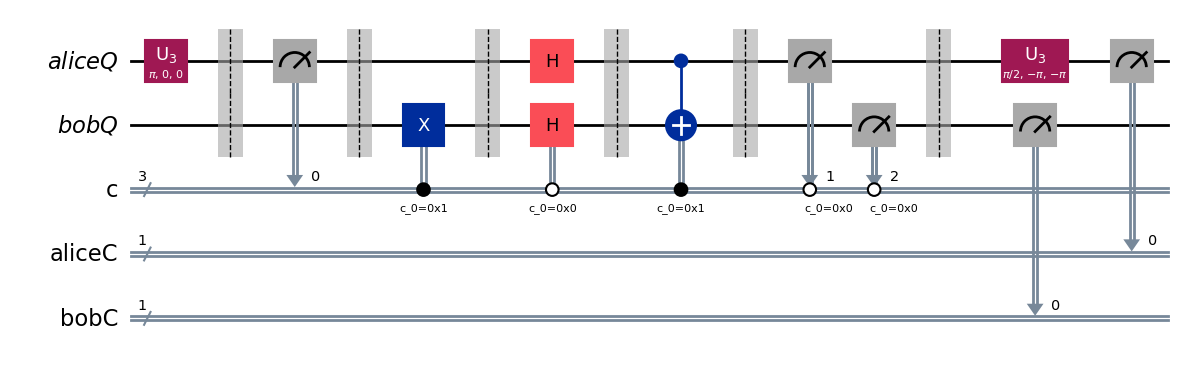

In [246]:
print("name: ", QCs[2].name)
QCs[2].draw('mpl')